# Logistic Regression
## Predicting a Category or Class

**ACKNOWLEDGEMENT**

**Some of the code in this notebook is based on John D. Wittenauer's notebooks that cover the exercises in Andrew Ng's course on Machine Learning on Coursera. I've also modified some code from Sebastian Raschka's book *Python Machine Learning*, and used some code from Sonya Sawtelle's [blog](https://sdsawtelle.github.io/blog/output/week3-andrew-ng-machine-learning-with-python.html). **

## What is Logistic Regression?

Despite the fancy technical name, logistic regression is not a scary thing. It just means predicting a class or category rather than a number. 

Or more accurately, it's about predicting a categorical value rather than a a numerical value. 

## Why do Logistic Regression?

Because many business problems are really classification problems in disguise.

- Will person A respond to my marketing email?
- Will customer B renew their subscription for our services? 
- Will this jet engine work well once it's installed on an aircraft?
- Will student C be accepted by Princeton?
- Is this bank note a counterfeit?

### Exercise 1
Can you think of a (business) problem you're familiar with that's really a classification problem in disguise? 

## The Problem We'll Tackle

How to distinguish a real from a fake banknote? 

Modern banknotes have a large number of subtle distinguishing characteristics like watermarks, background lettering, and holographic images.

It would be hard (and time consuming and even counterproductive) to write these down as a concrete set of rules. Especially as notes can age, tear, and get mangled in a number of ways these rules can start to get very complex. 

Can a machine learn to do it using image data?

Let's see...

## Load the Data

About the data. It comes from the [University of California at Irvine's repository of data sets](https://archive.ics.uci.edu/ml/datasets/banknote+authentication). According to the authors of the data, 
> "Data were extracted from images that were taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. [A] Wavelet Transform tool were used to extract features from images."

The features of the data are values from this wavelet transform process that the images were put through.

In [1]:
# Import our usual libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
# OS-independent way to navigate the file system
# Data directory is one directory up in relation to directory of this notebook
data_dir_root = os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + "Data")
# Where the file is
file_url = data_dir_root + os.sep + "forged-bank-notes.csv"
#file_url
# header=0 drops the header row in the csv file
data = pd.read_csv(file_url, header=0, names=['V1', 'V2', 'V3', 'V4', 'Genuine'])

In [3]:
# Number of rows and columns in the data
data.shape

(1372, 5)

In [4]:
# First few rows of the datastet
data.head()

,V1,V2,V3,V4,Genuine
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


## Step 1: Visualize the Data

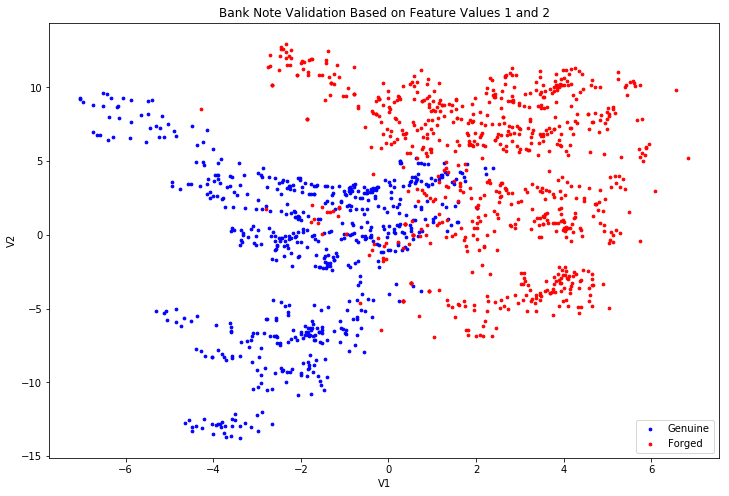

In [5]:
# Scatter of V1 versus V2
positive = data[data['Genuine'].isin([1])]
negative = data[data['Genuine'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['V1'], positive['V2'], s=30, c='b', marker='.', label='Genuine')
ax.scatter(negative['V1'], negative['V2'], s=30, c='r', marker='.', label='Forged')
ax.legend(loc='lower right')
ax.set_xlabel('V1')
ax.set_ylabel('V2')
plt.title('Bank Note Validation Based on Feature Values 1 and 2');

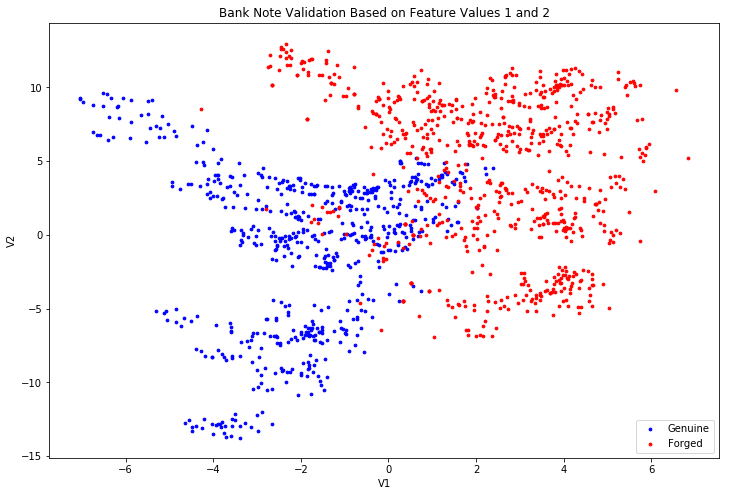

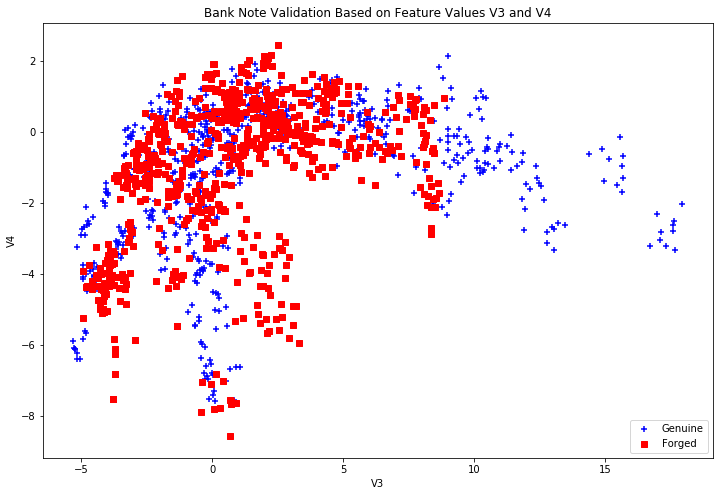

In [6]:
# Scatter of V3 versus V4
positive = data[data['Genuine'].isin([1])]
negative = data[data['Genuine'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['V3'], positive['V4'], s=30, c='b', marker='+', label='Genuine')
ax.scatter(negative['V3'], negative['V4'], s=30, c='r', marker='s', label='Forged')
ax.legend(loc='lower right')
ax.set_xlabel('V3')
ax.set_ylabel('V4')
plt.title('Bank Note Validation Based on Feature Values V3 and V4');

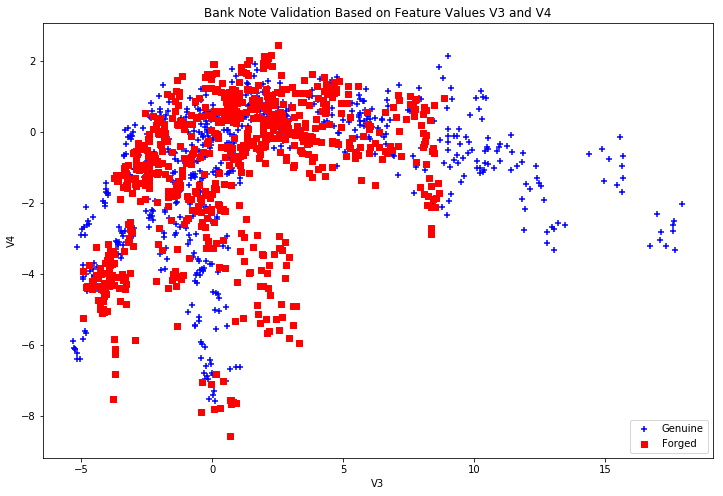

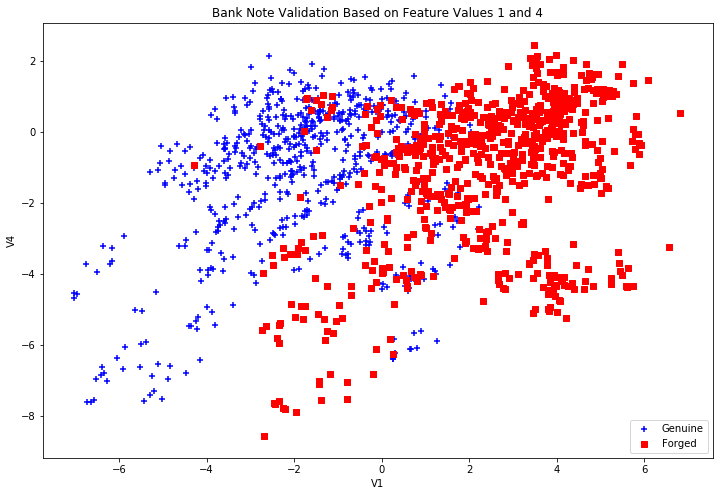

In [7]:
# Scatter of V1 versus V4
positive = data[data['Genuine'].isin([1])]
negative = data[data['Genuine'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['V1'], positive['V4'], s=30, c='b', marker='+', label='Genuine')
ax.scatter(negative['V1'], negative['V4'], s=30, c='r', marker='s', label='Forged')
ax.legend(loc='lower right')
ax.set_xlabel('V1')
ax.set_ylabel('V4')
plt.title('Bank Note Validation Based on Feature Values 1 and 4');

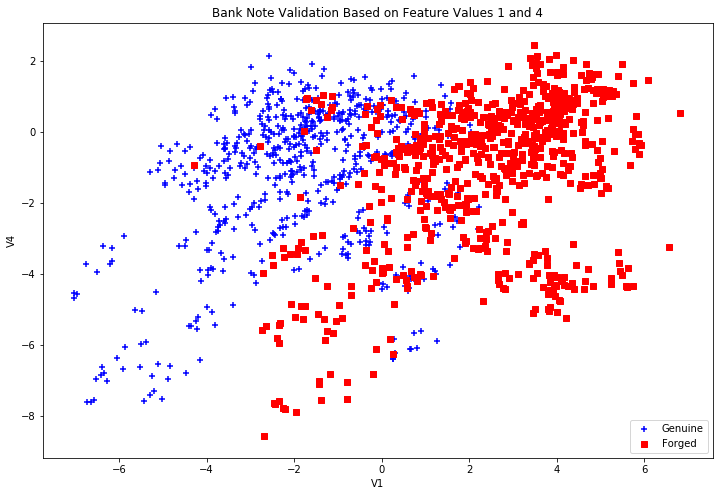

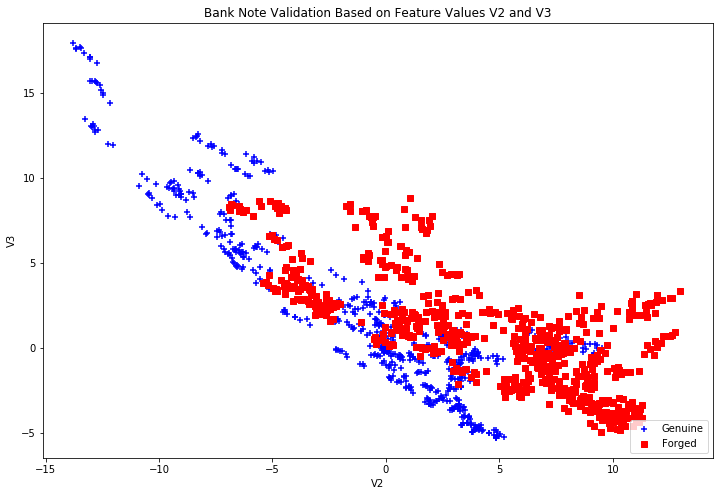

In [8]:
# Scatter of V2 versus V3
positive = data[data['Genuine'].isin([1])]
negative = data[data['Genuine'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['V2'], positive['V3'], s=30, c='b', marker='+', label='Genuine')
ax.scatter(negative['V2'], negative['V3'], s=30, c='r', marker='s', label='Forged')
ax.legend(loc='lower right')
ax.set_xlabel('V2')
ax.set_ylabel('V3')
plt.title('Bank Note Validation Based on Feature Values V2 and V3');

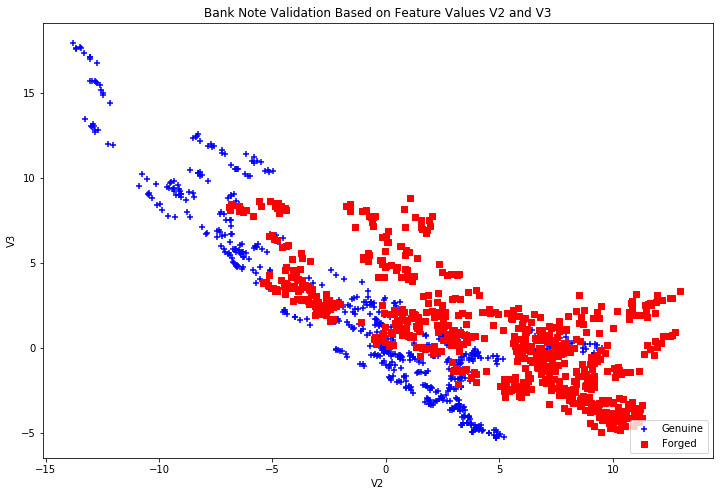

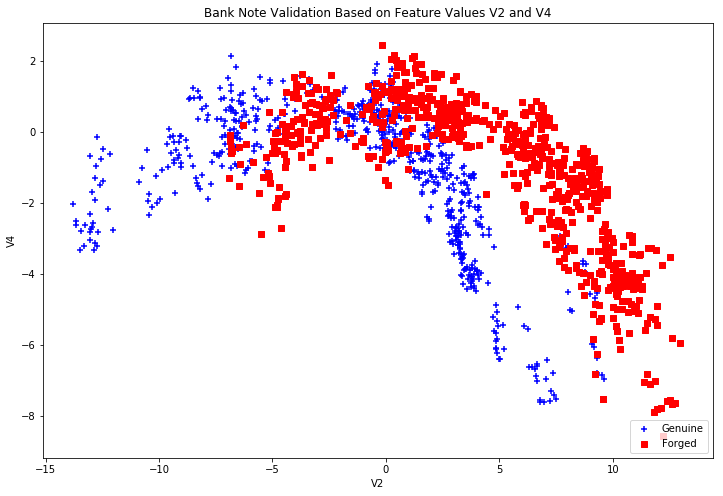

In [9]:
# Scatter of Skewness versus Entropy
positive = data[data['Genuine'].isin([1])]
negative = data[data['Genuine'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive['V2'], positive['V4'], s=30, c='b', marker='+', label='Genuine')
ax.scatter(negative['V2'], negative['V4'], s=30, c='r', marker='s', label='Forged')
ax.legend(loc='lower right')
ax.set_xlabel('V2')
ax.set_ylabel('V4')
plt.title('Bank Note Validation Based on Feature Values V2 and V4');

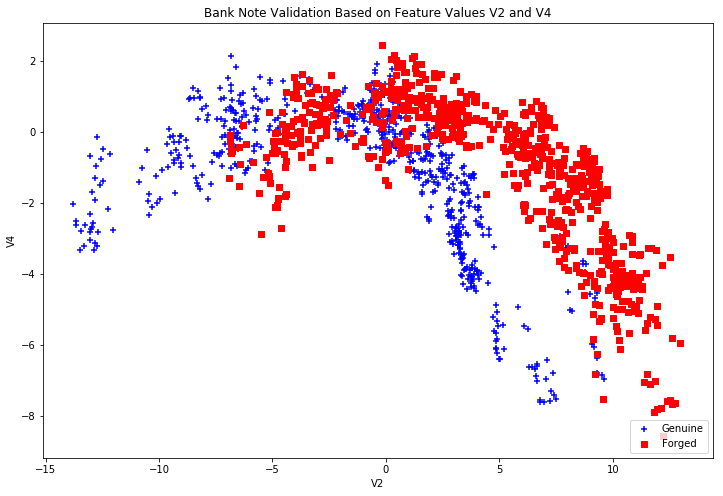

### Exercise 2

Use Orange to replicate the scatter plots for all features in the dataset. The data is available from the course's [GitHub repository](https://github.com/jsub10/MLCourse/blob/master/Data/forged-bank-notes.xlsx).

Let's use features V1 and V2 alone to begin with. In addition to keeping things simpler, it will let us visualize what's going on.

<img src="../Images/classification-lines.jpg" alt="Classification Boundaries" style="width:600px"/>

Right away we see that this doesn't even look like a regular regression problem -- there are two classes -- Genuine and Forged. These are not continuous values -- it's one or the other. 

Moreover, the classes don't separate cleanly. This is what we usually face in the real world. No matter how we try to separate these classes, we're probably never going to get it 100% right.

## Step 2: Define the Task You Want to Accomplish

Task = Classify a banknote as genuine or counterfeit given the values of its features V1 and V2.

### Step 2a: Identify the Inputs 

The inputs are the features V1 and V2 generated by the instrument reading the images (the wavelet transform tool).

In [10]:
# First few rows of the input
inputs = data[['V1', 'V2']]
inputs.head()

,V1,V2
0,3.62160,8.6661
1,4.54590,8.1674
2,3.86600,-2.6383
3,3.45660,9.5228
4,0.32924,-4.4552


### Step 2b: Identify the Output/Target

The output or target we'd like to predict is the feature called "Genuine". It takes the value 1 when the banknote is real and 0 when the banknote is counterfeit.

In [11]:
# First few rows of the output/target
output = data[['Genuine']]
output.head()

,Genuine
0,0
1,0
2,0
3,0
4,0


## Step 3: Define the Model

### Step 3a: Define the Features

We have 2 features: V1 and V2.

### Step 3b: Transform the Inputs Into an Output

Although the task we now face is different from the regression task, we're going to start just as we did before.

$$\hat{y} = w_{0} * x_{0}\ +\ w_{1} * x_{1} +\ w_{2} * x_{2}$$

It looks like the form of a linear regression and that's exactly what it is.

But now a twist...

When we transform the inputs V1 and V2 using the expression 

$$\hat{y} = w_{0} * x_{0}\ +\ w_{1} * x_{1} +\ w_{2} * x_{2}$$

we're going to end up with a numeric value. It might be 4.2 or -12.56 or whatever depending on the values you plug in for $w_{0}$, $w_{1}$, and $w_{2}$.

But what we *need* is an output of 0 or 1.

**Question**: How to go from a numeric (continuous) value like -12.56 to a categorical value like 0 or 1?

### The Sigmoid

The way to transform a numerical value into a categorical value is through something called a sigmoid. Here's what it looks like.

In [12]:
# Define the sigmoid function or transformation
# NOTE: ALSO PUT INTO THE SharedFunctions notebook
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

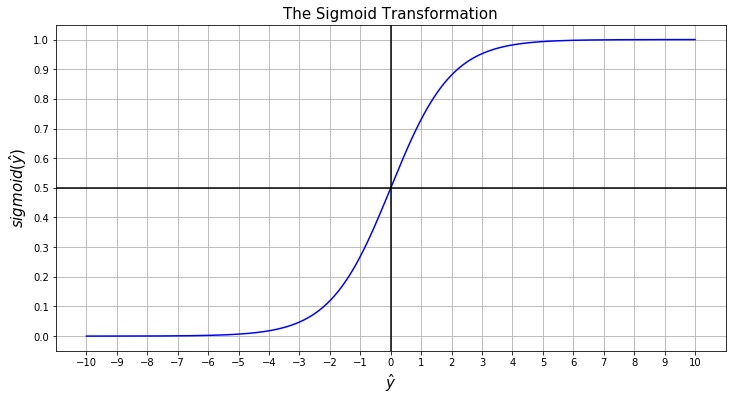

In [13]:
# Plot the sigmoid function
# Generate the values to be plotted
x_vals = np.linspace(-10,10,1000)
y_vals = [sigmoid(x) for x in x_vals]

# Plot the values
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(x_vals, y_vals, 'blue')
ax.grid()
# Draw some constant lines to aid visualization
plt.axvline(x=0, color='black')
plt.axhline(y=0.5, color='black')
plt.yticks(np.arange(0,1.1,0.1))
plt.xticks(np.arange(-10,11,1))
plt.xlabel(r'$\hat{y}$', fontsize=15)
plt.ylabel(r'$sigmoid(\hat{y})$', fontsize=15)
plt.title('The Sigmoid Transformation', fontsize=15)
ax.plot;

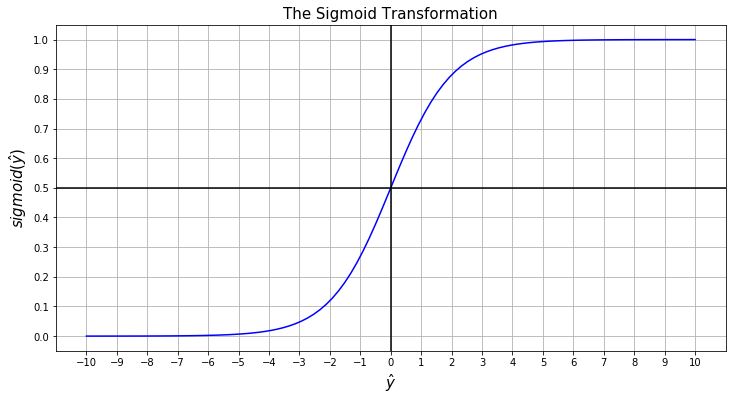

- Notice that the sigmoid is never less than zero or greater than 1.

- Although it looks like the sigmoid rapidly gets to 1 (on the positive side) and 0 on the negative side and stays there, mathematically speaking, the sigmoid *never* gets to 1 or 0 -- it gets closer and closer but never gets there.

Because the sigmoid can never be less than zero or greater than 1, the sigmoid can take any number and convert it into another number *between 0 and 1*.

But that *still* doesn't get us to just 1 or just 0.

If you look at the sigmoid above, you'll see that when $\hat{y}$ is around 5 or higher, $sigmoid(\hat{y})$ is very close to 1.

Similarly, when $\hat{y}$ is around -5 or lower, $sigmoid(\hat{y})$ is very close to 0.

But we develop this much simpler rule:

- When the value of $sigmoid(\hat{y})$ is greater than 0.5, treat it as 1.
- When the value of $sigmoid(\hat{y})$ is less than or equal to 0.5, treat it as a 0.


That's it. A system for going from any number (positive or negative) to either a 0 or a 1.

Let's recap what we've done so far to build a model for logistic regression.

- A model is a scheme for transforming inputs to an output.
- The model for logistic regression transforms the inputs of each row of the dataset to an output in three steps:
  - First, it uses the same scheme we used for regression: $\hat{y} = w_{0} * x_{0}\ +\ w_{1} * x_{1} +\ w_{2} * x_{2}$
  - Then it takes $\hat{y}$ and transforms it using the sigmoid into $sigmoid(\hat{y})$.
  - Finally, 
    - if $sigmoid(\hat{y})$ is greater than 0.5, the output is equal to 1.
    - if $sigmoid(\hat{y})$ is less than or equal to 0.5, the output is equal to 0.

### Step 3c: Clarify the Parameters of the Model

Just as they were before, the parameters of the model are still $w_{0}$, $w_{1}$, and $w_{2}$.

## Step 4: Define the Penalty for Getting it Wrong

Here's where things change quite a bit from what we've seen in regression.

A penalty applies when the model (i.e., the scheme for transforming inputs to an ouput) gives the wrong answer.

The intuition is: the more wrong the model output is, the higher the penalty should be.

Let's see what this looks like.

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


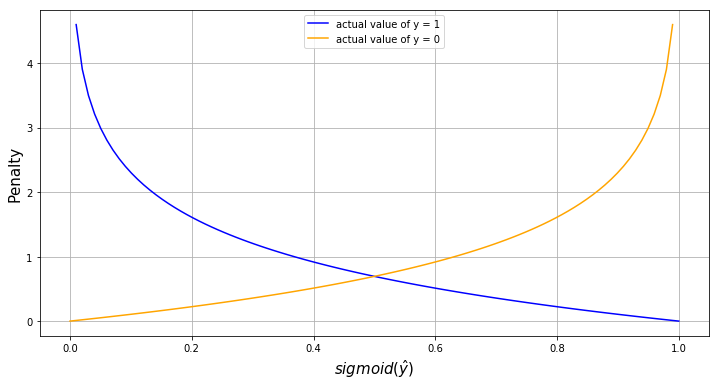

In [14]:
# Visualize the penalty function when y = 1 and y = 0
x_vals = np.linspace(0,1,100)
y_1_vals = -np.log(x_vals)
y_0_vals = -np.log(1 - x_vals)

fig, ax = plt.subplots(figsize=(12,6))
ax.grid()
ax.plot(x_vals, y_1_vals, color='blue', linestyle='solid', label='actual value of y = 1')
ax.plot(x_vals, y_0_vals, color='orange', linestyle='solid', label='actual value of y = 0')
plt.legend(loc='upper center')
plt.xlabel(r'$sigmoid(\hat{y})$', fontsize=15)
plt.ylabel('Penalty', fontsize=15)
ax.plot;

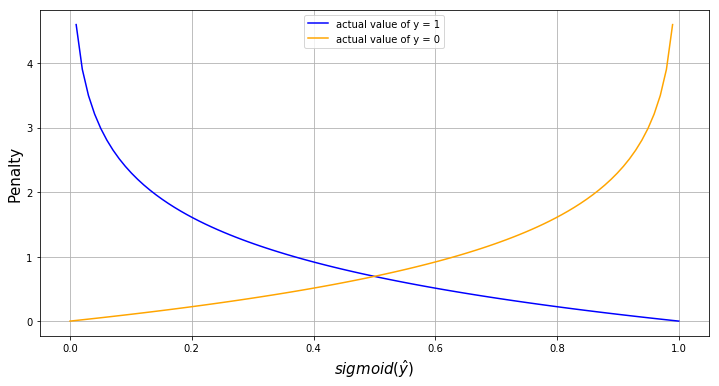

Keep your eye on the orange curve. This is for the case when the actual value of a row in the dataset is 0 (the banknote is a fake). If the banknote is a fake and say $\hat{y}$ is 7, then $sigmoid(\hat{y})$ is going to be close to 1, say 0.9. This means that the penalty is going to be very high because the orange curve increases rapidly in value as it approaches 1.

Similarly, when the actual value of the dataset is 1, the blue penalty curve comes into play. If $\hat{y}$ is 7, then once again $sigmoid(\hat{y})$ is going to be close to 1, say 0.9. But in this case the penalty is very low because the blue curve decreases rapidly in value as it approaches 1.

<img src="../Images/inputs-to-penalty.png" alt="Going from Inputs to the Penalty" width="500px"/>

<img src="../Images/logistic-regression-dataset-view.png" alt="Going from Inputs to the Penalty" width="500px"/>

## Step 5: Find the Parameter Values that Minimize the Penalty

We've set up the logistic regression model and we'll use the familiar algorithm of gradient descent to learn the optimal values of the parameters.

In [15]:
# Set up the training data
X_train = inputs.values
#X_train.shape

In [16]:
# Set up the target data 
y = output.values

# Change the shape of y to suit scikit learn's requirements
y_train = np.array(list(y.squeeze()))
#y_train.shape

In [17]:
# Set up the logistic regression model from SciKit Learn
from sklearn.linear_model import LogisticRegression
# Solvers that seem to work well are 'liblinear' and 'newton-cg"
lr = LogisticRegression(C=100.0, random_state=0, solver='liblinear', verbose=2)

In [18]:
# Train the model and find the optimal parameter values
lr.fit(X_train, y_train)

[LibLinear]

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=2, warm_start=False)

In [19]:
# These are the optimal values of w0, w1 and w2
w0 = lr.intercept_[0]
w1 = lr.coef_.squeeze()[0]
w2 = lr.coef_.squeeze()[1]
print("w0: {}\nw1: {}\nw2: {}".format(w0, w1, w2))

w0: 0.5865973329054549
w1: -1.1107052345243296
w2: -0.27255003089824


## Step 6: Use the Model and Optimal Parameter Values to Make Predictions

In [20]:
# Genuine or fake for the entire data set
y_pred = lr.predict(X_train)
print(y_pred)

[0 0 0 ..., 1 1 1]


In [21]:
# How do the predictions compare with the actual labels on the data set?
y_train == y_pred

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [22]:
# The probabilities of [Genuine = 0, Genuine = 1]
y_pred_probs = lr.predict_proba(X_train)
print(y_pred_probs)

[[  9.96975193e-01   3.02480710e-03]
 [  9.98756502e-01   1.24349790e-03]
 [  9.52043682e-01   4.79563183e-02]
 ..., 
 [  2.20318273e-04   9.99779682e-01]
 [  1.08020600e-03   9.98919794e-01]
 [  2.68767854e-02   9.73123215e-01]]


In [23]:
# Where did the model misclassify banknotes?
errors = data[data['Genuine'] != y_pred]
#errors

In [24]:
# Following Sonya Sawtelle 
# (https://sdsawtelle.github.io/blog/output/week3-andrew-ng-machine-learning-with-python.html)
# This is the classifier boundary line when z=0
x1 = np.linspace(-6,6,100)  # Array of exam1 value
x2 = (-w0/w2) - (w1/w2)*x1  # Corresponding V2 values along the line z=0

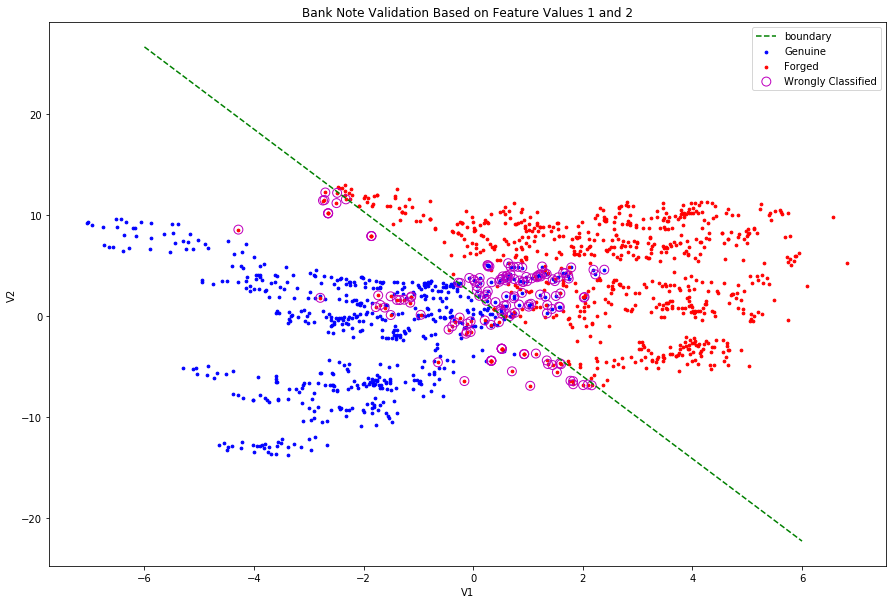

In [25]:
# Following Sonya Sawtelle 
# (https://sdsawtelle.github.io/blog/output/week3-andrew-ng-machine-learning-with-python.html)

# Scatter of V1 versus V2
positive = data[data['Genuine'].isin([1])]
negative = data[data['Genuine'].isin([0])]

fig, ax = plt.subplots(figsize=(15,10))
#colors = ["r", "b"]
#la = ["Forged", "Genuine"]
#markers = [colors[gen] for gen in data['Genuine']] # this is a cool way to color the categories!
#labels = [la[gen] for gen in data['Genuine']]
#ax.scatter(data['V1'], data['V2'], color=markers, s=10, label=labels)

ax.scatter(positive['V1'], positive['V2'], s=30, c='b', marker='.', label='Genuine')
ax.scatter(negative['V1'], negative['V2'], s=30, c='r', marker='.', label='Forged')

ax.set_xlabel('V1')
ax.set_ylabel('V2')

# Now plot black circles around data points that were incorrectly predicted
ax.scatter(errors["V1"], errors["V2"], facecolors="none", edgecolors="m", s=80, label="Wrongly Classified")

# Finally plot the line which represents the decision boundary
ax.plot(x1, x2, color="green", linestyle="--", marker=None, label="boundary")

ax.legend(loc='upper right')

plt.title('Bank Note Validation Based on Feature Values 1 and 2');

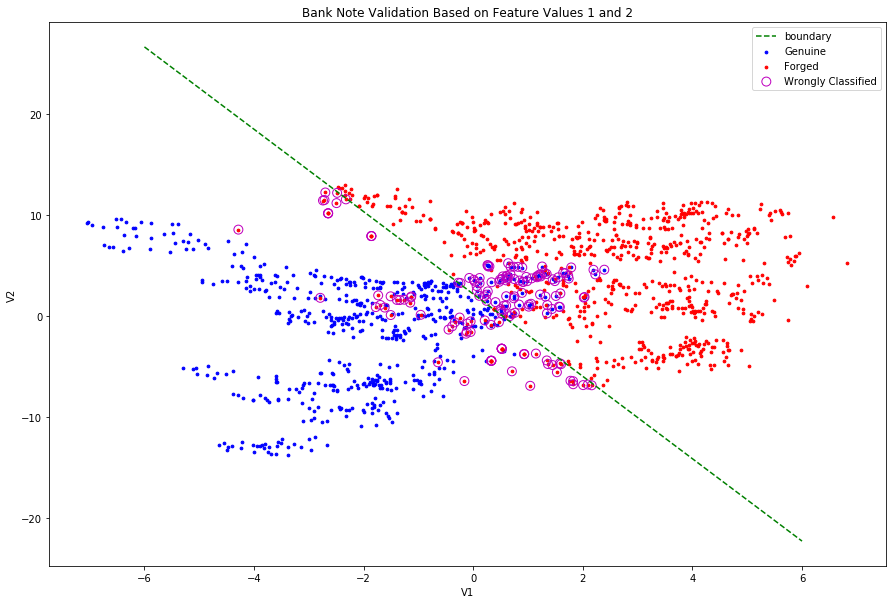

Even though we've used the sigmoid function to transform $\hat{y}$ values, the $\hat{y}$ values are themselves the result of a simple linear model: 

$$\hat{y} = w_{0} * x_{0}\ +\ w_{1} * x_{1} +\ w_{2} * x_{2}$$

But clearly, the V1-V2 values of genuine and forged banknotes are somewhat mixed up -- a line (or something straight) is never going to classify the banknotes reliably. There are many mistakes as denoted by the points circled in magenta in the diagram we saw earlier.

What if we made the model non-linear? We consider that in the next session.

## Step 7: Measure the Performance of the Model

We're going to delay this step until the next session.

## Summary

- We've taken the same basic scheme of transforming inputs and into and output that we used for linear regression and turned it into a way to classify things.

- The sigmoid is used to convert a numerical (continous) value into a categorical (discrete) value. This is done in two steps.
 - First, the value of the sigmoid is returned. This is a numerical value between 0 and 1 and can be interpreted as the probability of belonging to a particular class.
 - Second, we use a simple "cutoff" rule -- if the sigmoid value is greater than 0.5, the class is a 1; otherwise it's a 0.